In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Question Answering with Documents using LangChain 🦜️🔗 and Vertex AI Matching Engine

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/examples/document-qa/question_answering_documents_langchain_matching_engine.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/examples/document-qa/question_answering_documents_langchain_matching_engine.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/language/examples/document-qa/question_answering_documents_langchain_matching_engine.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>


## Overview

This notebook demonstrates implementing a Question Answering (QA) system to show how to improve LLM's response by augmenting LLM's knowledge with external data sources such as documents, websites. The notebooks uses Vertex AI PaLM API for [Text](https://cloud.google.com/vertex-ai/docs/generative-ai/text/text-overview), [Embeddings for Text API](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings), [Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) and [LangChain 🦜️🔗](https://python.langchain.com/en/latest/). 

### Context

Large Language Models (LLMs) have improved quantitatively and qualitatively. They can learn new abilities without being directly trained on them. However, there are constraints with LLMs - they are unaware of events after training and it is almost impossible to trace the sources to their responses. It is preferred for LLM based systems to cite their sources and be grounded in facts.

To solve for the constraints, one of the approaches is to augment the prompt sent to LLM with relevant data retrieved from an external knowledge base through Information Retrieval (IR) mechanism. This approach is called Retrieval Augmented Generation (RAG), also known as Generative QA in the context of the QA task. There are two main components in RAG based architecture: (1) Retriever and (2) Generator.

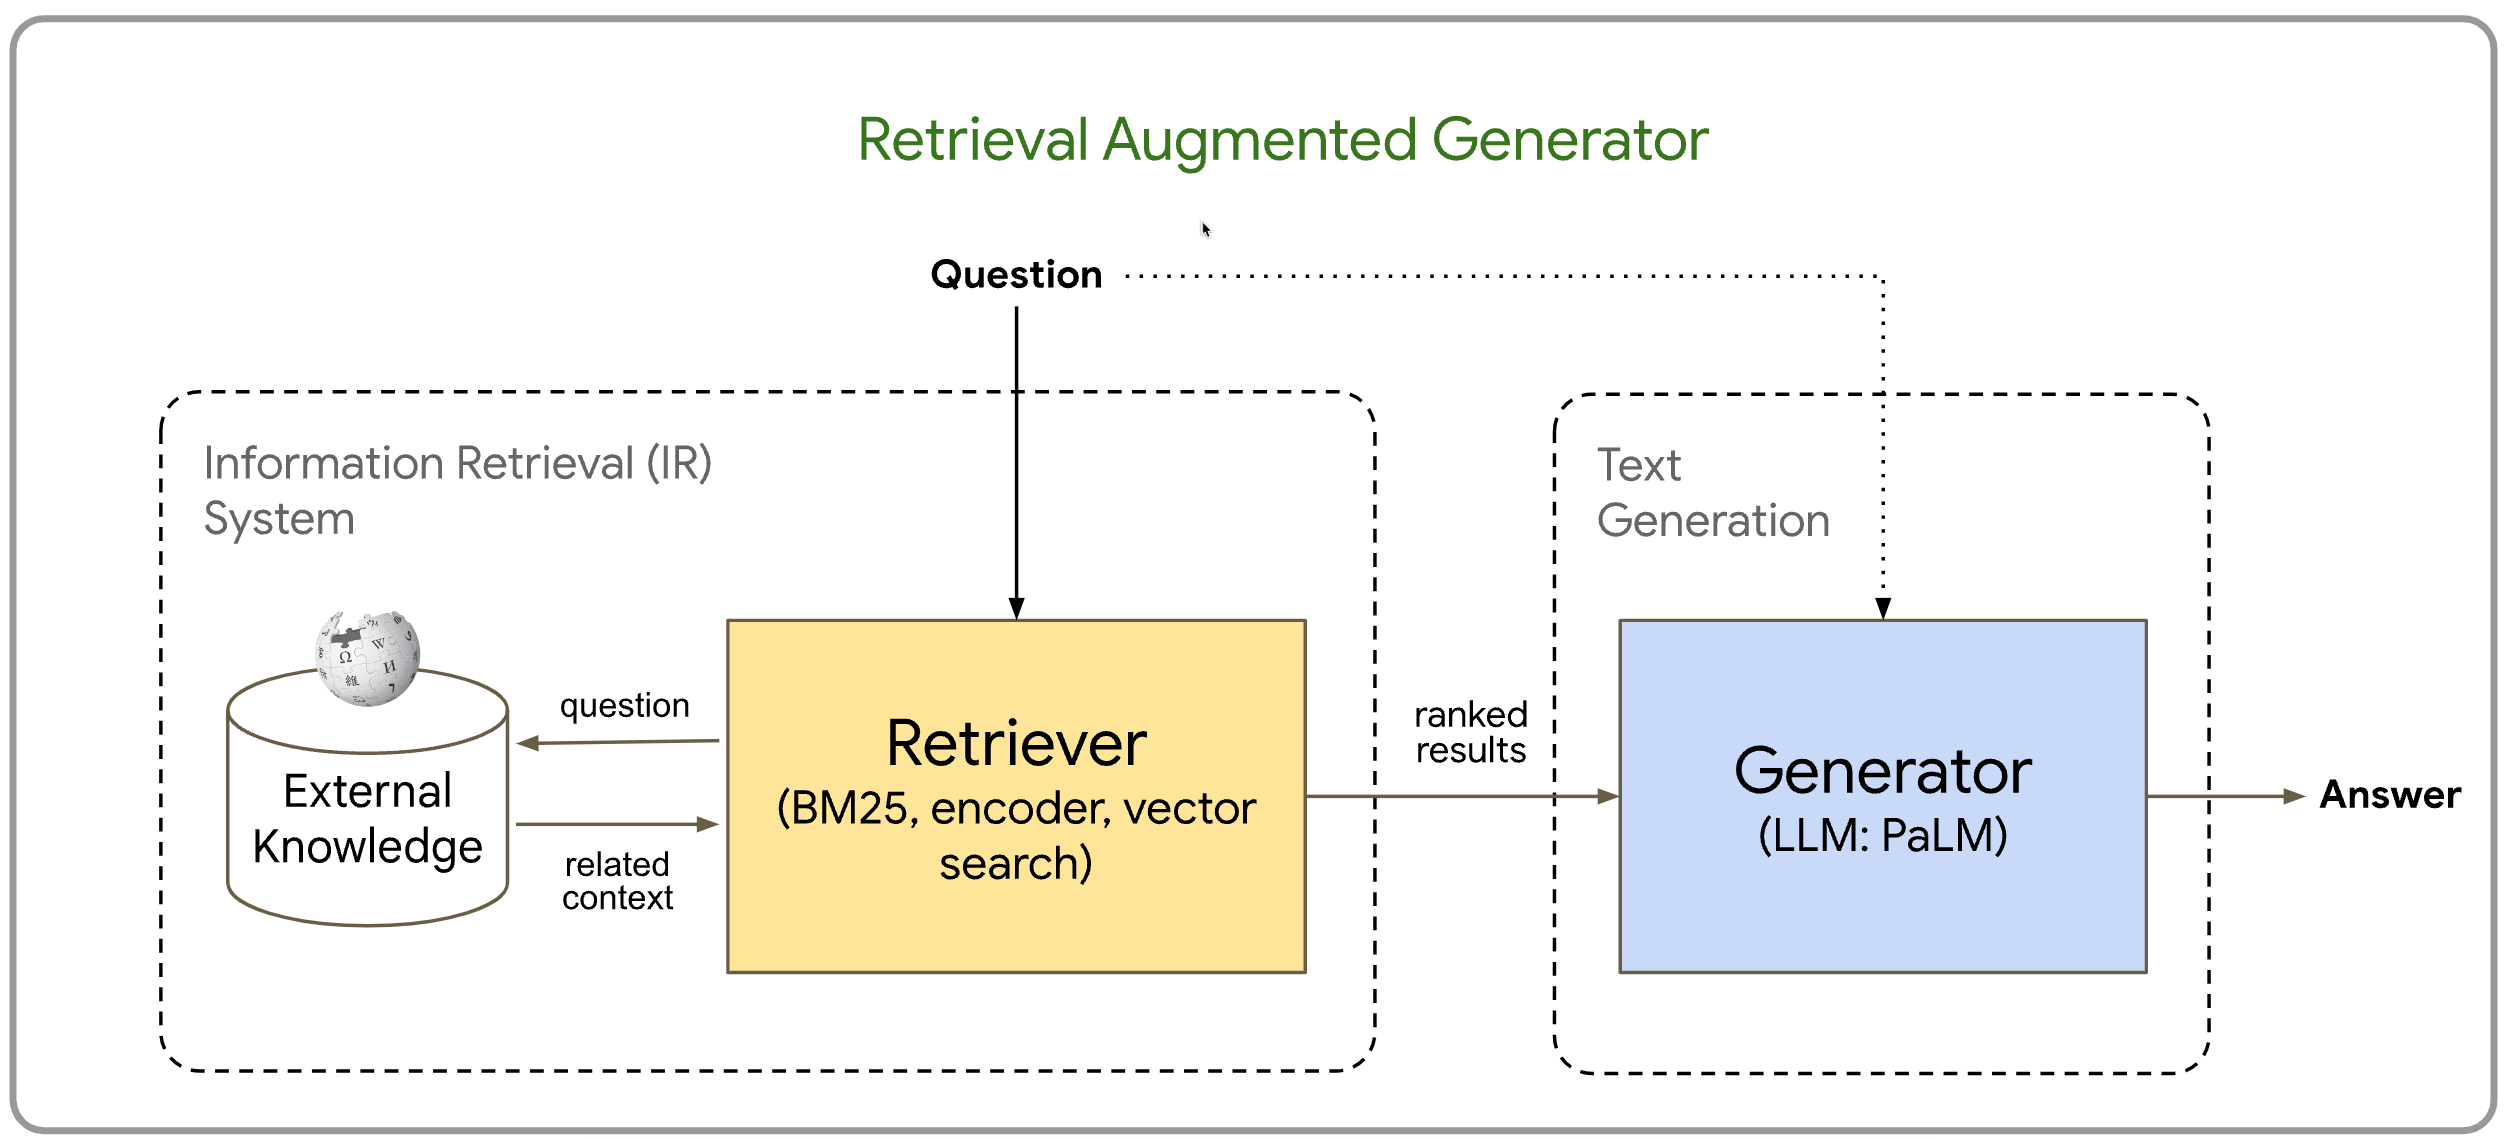

- **Retriever:** The knowledge base is integrated with an IR mechanism, also known as a Retriever, to retrieve relevant snippets from documents based on the user's query. The knowledge base can be your own document corpus, databases, or APIs. The Retriever can be implemented using term-based search (e.g. keyword, TF-IDF). Another approach is to use vector search based on dense embeddings, which captures semantically rich information in the text, leading to much more efficient information retrieval. The relevant snippets retrieved from the IR mechanism are passed as “context” to the next stage, Generator.
- **Generator:** The context - relevant  snippets from the knowledge base - are passed to an LLM to generate a well formed response grounded by the source documents.

This approach extracts relevant info from knowledge base to respond to queries, avoiding LLM memory limits and hallucinations. An added advantage is you can keep knowledge base up-to-date with new documents, ensuring grounded, accurate, relevant responses.

### High Level Flow

Following is the high level flow of implementation:

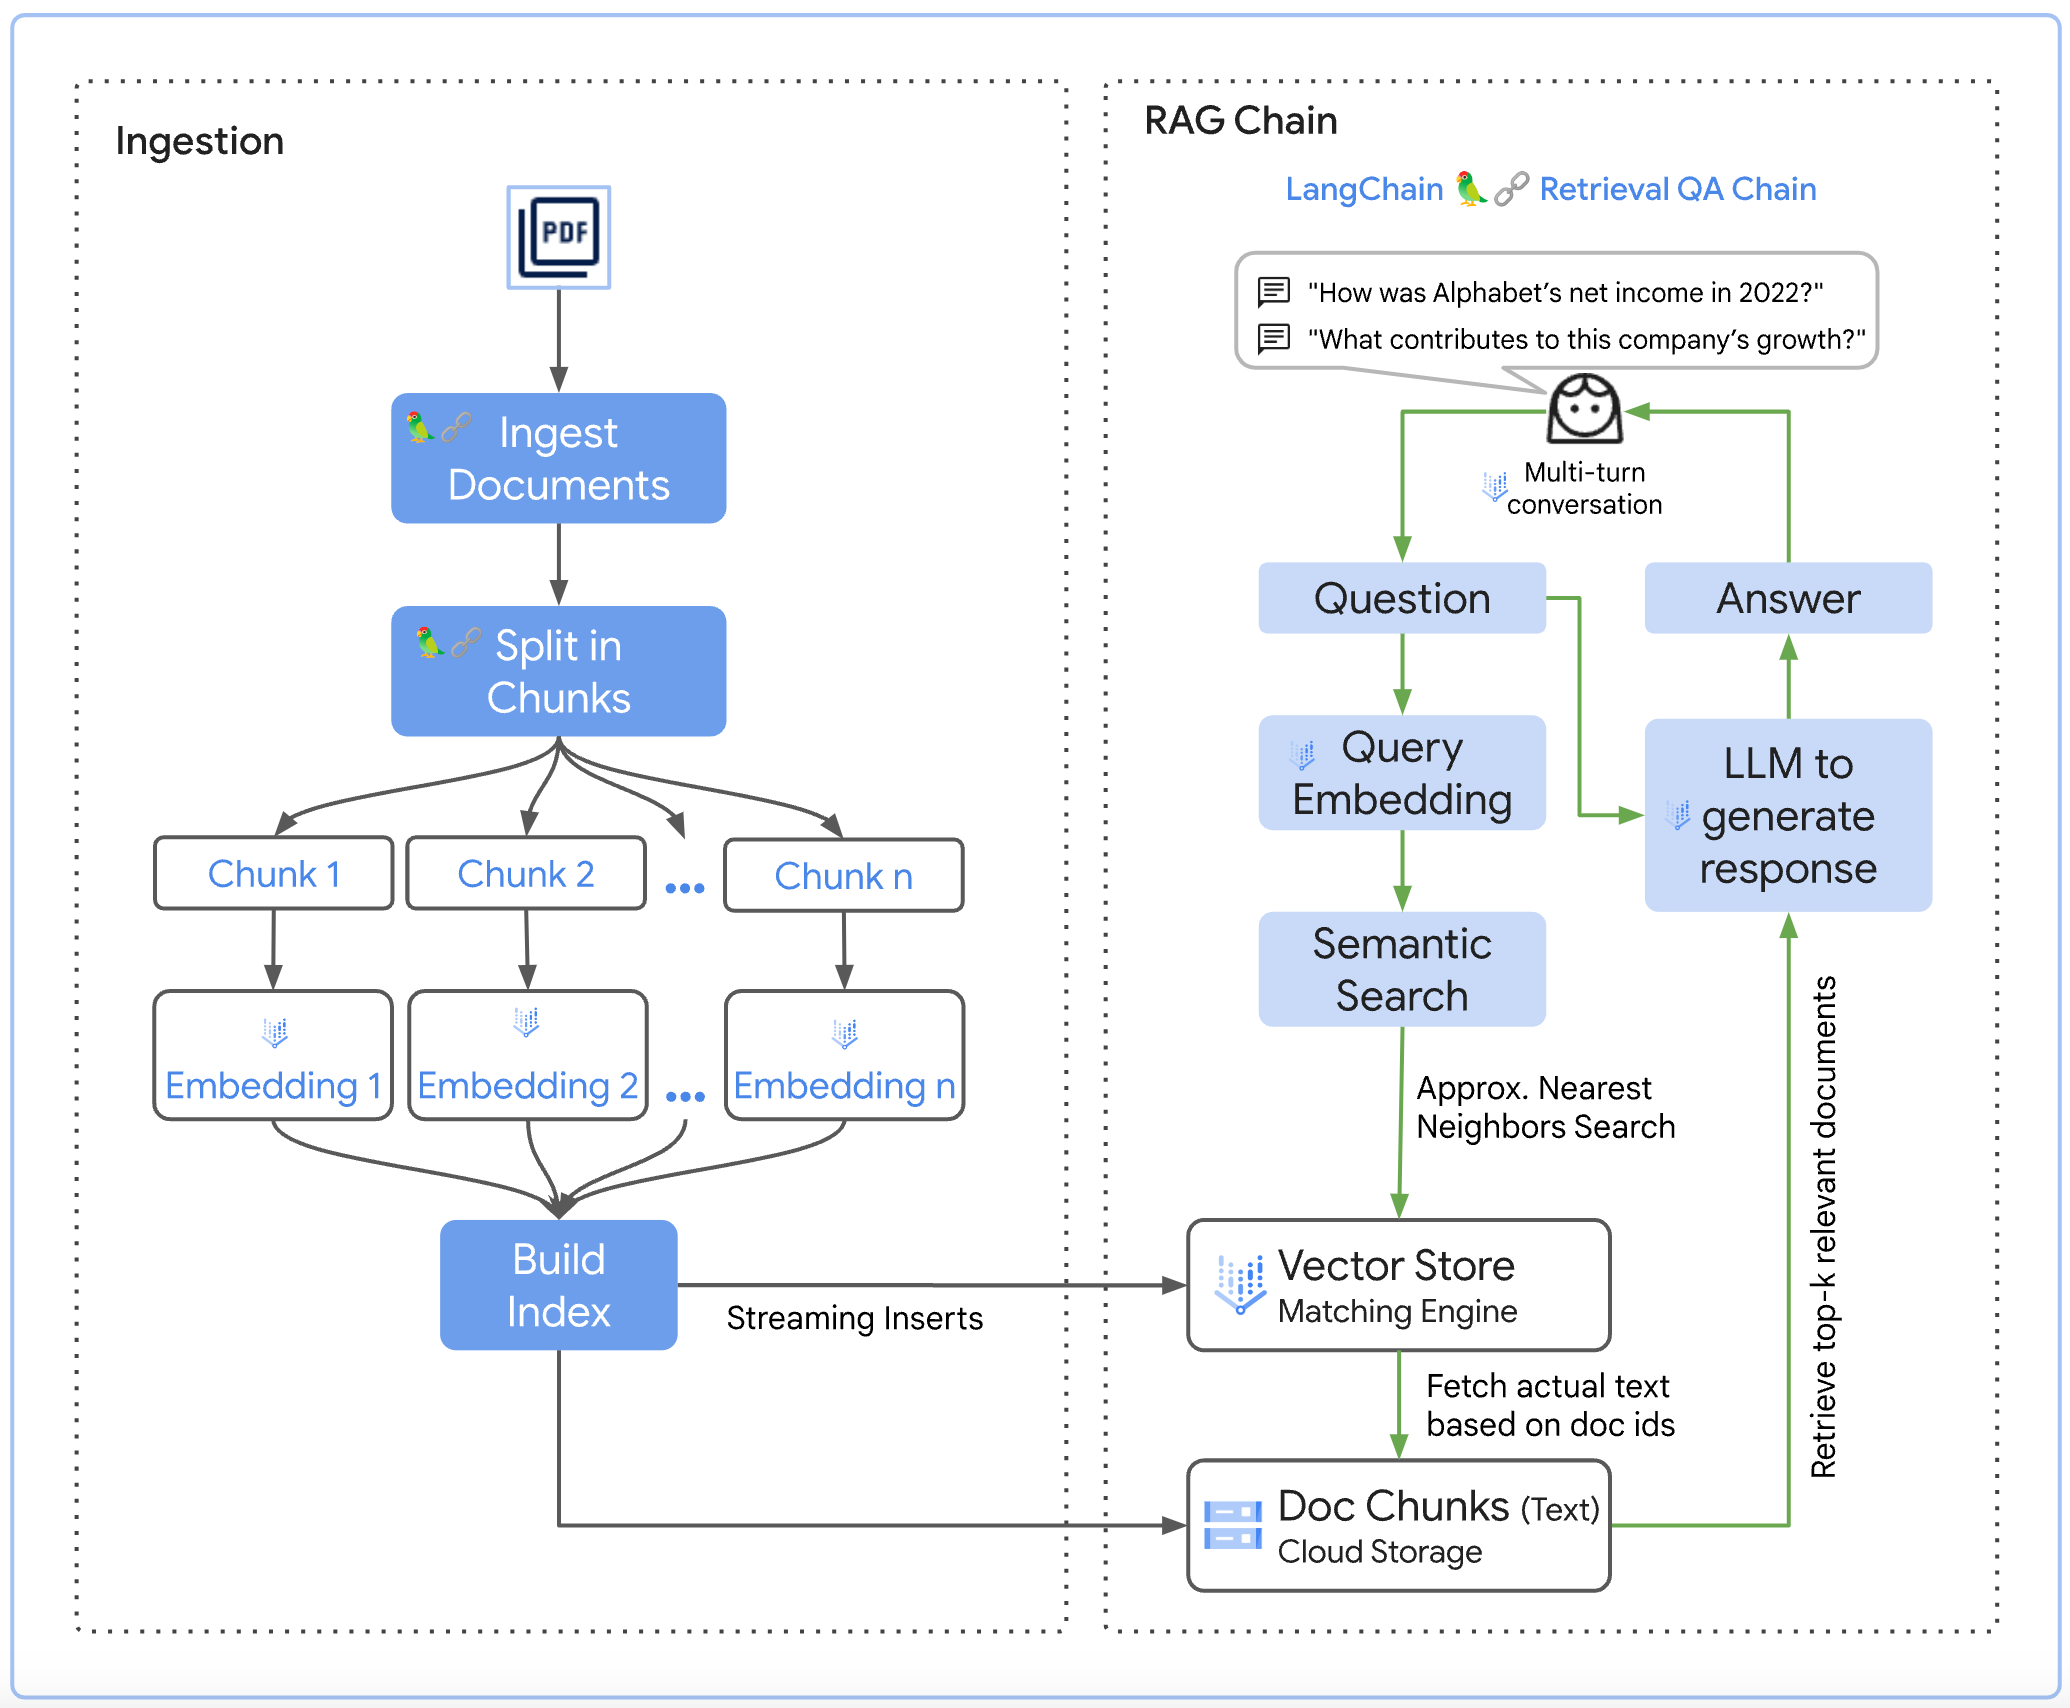

Following are the sequence of tasks when ingesting knowledge base sources into the vector store:
- Read the documents (PDF files in this notebook)
- Chunk the documents  to include relevant parts of the document as context to the prompt
- Generate embeddings for each chunked document
- Add embedding to the vector store

Following is the data flow at runtime when user prompts the model:
- User enters a prompt or asks a question as a prompt
- Generated embedding for the user prompt to capture semantics
- Search the vector store to retrieve the nearest embeddings (relevant documents) closer to the prompt
- Fetch the actual text for the retrieved embeddings to add as context to the user's prompt
- Add the retrieved documents as context to the user's prompt
- Send the updated prompt to the LLM
- Return a summarized response to the user with references to the sources from the knowledge base

### Objective

This notebooks demonstrates implementing a QA system based on retrieval augmented generation pattern that responds to questions based on a private collection of documents and adds references to the relevant documents. The datasets used as a private document corpus is a sample of Google published research papers. 

You will learn how to:
- [x] Use LangChain RetrievalQA chain with built-in integration for Vertex AI PaLM API for [Text](https://python.langchain.com/en/latest/modules/models/llms/integrations/google_vertex_ai_palm.html), [Embeddings API](https://python.langchain.com/en/latest/modules/models/text_embedding/examples/google_vertex_ai_palm.html) and [Vertex AI Matching Engine](https://python.langchain.com/en/latest/modules/indexes/vectorstores/examples/matchingengine.html)
- [x] Extract text from PDF files stored on Cloud Storage bucket
- [x] Generate embeddings using Vertex AI Embedding API to generate embeddings to capture semantics
- [x] [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) as a managed vector store on cloud to store the generated embeddings
- [x] Query Matching Engine index and return relevant results
- [x] Vertex AI PaLM API for Text as LLM to synthesize results and respond to the user query

**NOTE**: The notebook uses custom Matching Engine wrapper with LangChain to support streaming index updates and deploying index on public endpoint.

### Costs

This tutorial uses billable components of Google Cloud Platform (GCP):

- [Generative AI on Vertex AI](https://cloud.google.com/vertex-ai/pricing#generative_ai_models)
- [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/pricing#matchingengine)
- [Vertex AI Workbench [optional]](https://cloud.google.com/vertex-ai-workbench)
- [Cloud Storage](https://cloud.google.com/storage)

Learn about [Vertex AI Pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage Pricing](https://cloud.google.com/storage/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

---

## Getting Started

### Install Vertex AI SDK, other packages and their dependencies

Install the following packages required to execute this notebook.

In [ ]:
# Install Vertex AI LLM SDK
! pip install --user google-cloud-aiplatform==1.27.0 langchain==0.0.201

# Dependencies required by Unstructured PDF loader
! sudo apt -y -qq install tesseract-ocr libtesseract-dev 
! sudo apt-get -y -qq install poppler-utils
! pip install --user unstructured==0.7.5 pdf2image==1.16.3 pytesseract==0.3.10 pdfminer.six

# For Matching Engine integration dependencies (default embeddings)
! pip install --user tensorflow_hub==0.13.0 tensorflow_text==2.12.1

**Colab only**: Uncomment the following cell to restart the kernel or use the button to restart the kernel. For Vertex AI Workbench you can restart the terminal using the button on top.

In [ ]:
# # Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [ ]:
# from google.colab import auth

# auth.authenticate_user()

### Import libraries

In [ ]:
import json
import textwrap
# Utils
import time
import uuid
from typing import List

import numpy as np

# Vertex AI
from google.cloud import aiplatform
import vertexai

print(f"Vertex AI SDK version: {aiplatform.__version__}")

# Langchain
import langchain

print(f"LangChain version: {langchain.__version__}")

from langchain.chains import RetrievalQA
from langchain.document_loaders import GCSDirectoryLoader
from langchain.embeddings import VertexAIEmbeddings
from langchain.llms import VertexAI
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pydantic import BaseModel

# Import custom Matching Engine packages
from utils.matching_engine import MatchingEngine
from utils.matching_engine_utils import MatchingEngineUtils

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI SDK
vertexai.init(project=PROJECT_ID, location=REGION)

Next you will define some utility functions that you will use for the Vertex AI Embeddings API

In [ ]:
# Utility functions for Embeddings API with rate limiting
def rate_limit(max_per_minute):
    period = 60 / max_per_minute
    print("Waiting")
    while True:
        before = time.time()
        yield
        after = time.time()
        elapsed = after - before
        sleep_time = max(0, period - elapsed)
        if sleep_time > 0:
            print(".", end="")
            time.sleep(sleep_time)


class CustomVertexAIEmbeddings(VertexAIEmbeddings, BaseModel):
    requests_per_minute: int
    num_instances_per_batch: int

    # Overriding embed_documents method
    def embed_documents(self, texts: List[str]):
        limiter = rate_limit(self.requests_per_minute)
        results = []
        docs = list(texts)

        while docs:
            # Working in batches because the API accepts maximum 5
            # documents per request to get embeddings
            head, docs = (
                docs[: self.num_instances_per_batch],
                docs[self.num_instances_per_batch :],
            )
            chunk = self.client.get_embeddings(head)
            results.extend(chunk)
            next(limiter)

        return [r.values for r in results]

### Initialize LangChain Models

You initialize LangChain Models with the pre-trained text, chat and embeddings generation model called `text-bison@001`, `chat-bison@001` and `textembedding-gecko@001` respectively.

In [ ]:
# Text model instance integrated with langChain
llm = VertexAI(
    model_name="text-bison@001",
    max_output_tokens=1024,
    temperature=0.2,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

# Embeddings API integrated with langChain
EMBEDDING_QPM = 100
EMBEDDING_NUM_BATCH = 5
embeddings = CustomVertexAIEmbeddings(
    requests_per_minute=EMBEDDING_QPM,
    num_instances_per_batch=EMBEDDING_NUM_BATCH,
)

---

## STEP 1: Create Matching Engine Index and Endpoint for Retrieval


[Embeddings](https://cloud.google.com/blog/topics/developers-practitioners/meet-ais-multitool-vector-embeddings) are a way of representing data as n-dimensional vector, in a space where the locations of those points in space are semantically meaningful. These embeddings can be then used to find similar data points. You can get text embeddings using [Vertex AI Embeddings API](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings). These embeddings are managed using a vector database.


[Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) is a Google Cloud managed vector database, which stores data as high-dimensional vectors (embeddings) and can find the most similar vectors from over a billion vectors. Matching Engine's Approximate Nearest Neigbors (ANN) service can serve similarity-matching queries at high queries per second (QPS). Unlike vector stores that run locally, Matching Engine is optimized for scale (multi-million and billion vectors) and it's an enterprise ready engine.

As part of the environment setup, create an index on Vertex AI Matching Engine and deploy the index to an Endpoint. Index Endpoint can be [public](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-public) or [private](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-vpc). This notebook uses a **Public endpoint**.

<br/>

Refer to the [Matching Engine documentation](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) for details.

<br/>

<div class="alert alert-block alert-warning">
<b>⚠️ NOTE: Please note creating an Index on Matching Engine and deploying the Index to an Index Endpoint can take up to 1 hour.</b>
</div>

- Configure parameters to create Matching Engine index
    - `ME_REGION`: Region where Matching Engine Index and Index Endpoint are deployed
    - `ME_INDEX_NAME`: Matching Engine index display name
    - `ME_EMBEDDING_DIR`: Cloud Storage path to allow inserting, updating or deleting the contents of the Index
    - `ME_DIMENSIONS`: The number of dimensions of the input vectors. Vertex AI Embedding API generates 768 dimensional vector embeddings.

In [ ]:
ME_REGION = "us-central1"
ME_INDEX_NAME = f"{PROJECT_ID}-me-index"  # @param {type:"string"}
ME_EMBEDDING_DIR = f"{PROJECT_ID}-me-bucket"  # @param {type:"string"}
ME_DIMENSIONS = 768  # when using Vertex PaLM Embedding

Make a Google Cloud Storage bucket for your Matching Engine index

In [ ]:
! gsutil mb -l us-central1 $ME_EMBEDDING_DIR

- Create a dummy embeddings file to initialize when creating the index

In [ ]:
# dummy embedding
init_embedding = {"id": str(uuid.uuid4()), "embedding": list(np.zeros(ME_DIMENSIONS))}

# dump embedding to a local file
with open("embeddings_0.json", "w") as f:
    json.dump(init_embedding, f)

# write embedding to Cloud Storage
! gsutil cp embeddings_0.json {ME_EMBEDDING_DIR}/init_index/embeddings_0.json

### Create Index

You can [create index](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index#create-index) on Vertex AI Matching Engine for batch updates or streaming updates. 

This notebook creates Matching Engine Index:
- With [streaming updates](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index#create-stream) 
- With default configuration - e.g. small shard size

You can [update the index configuration](https://cloud.google.com/vertex-ai/docs/matching-engine/configuring-indexes) in the Matching Engine utilities script.

<br/>

While the index is being created and deployed, you can read more about Matching Engine's ANN service which uses a new type of vector quantization developed by Google Research: [Accelerating Large-Scale Inference with Anisotropic Vector Quantization](https://arxiv.org/abs/1908.10396).

For more information about how this works, see [Announcing ScaNN: Efficient
Vector Similarity Search](https://ai.googleblog.com/2020/07/announcing-scann-efficient-vector.html).

In [ ]:
mengine = MatchingEngineUtils(PROJECT_ID, ME_REGION, ME_INDEX_NAME)

In [ ]:
index = mengine.create_index(
    embedding_gcs_uri=f"gs://{ME_EMBEDDING_DIR}/init_index",
    dimensions=ME_DIMENSIONS,
    index_update_method="streaming",
    index_algorithm="tree-ah",
)
if index:
    print(index.name)

### Deploy Index to Endpoint

Deploy index to Index Endpoint on Matching Engine. This notebook [deploys the index to a public endpoint](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-public). The deployment operation creates a  public endpoint that will be used for querying the index for approximate nearest neighbors.

For deploying index to a Private Endpoint, refer to the [documentation](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-vpc) to set up pre-requisites.

In [ ]:
index_endpoint = mengine.deploy_index()
if index_endpoint:
    print(f"Index endpoint resource name: {index_endpoint.name}")
    print(
        f"Index endpoint public domain name: {index_endpoint.public_endpoint_domain_name}"
    )
    print("Deployed indexes on the index endpoint:")
    for d in index_endpoint.deployed_indexes:
        print(f"    {d.id}")

---

## STEP 2: Add Document Embeddings to Matching Engine - Vector Store

This step ingests and parse PDF documents, split them, generate embeddings and add the embeddings to the vector store. The document corpus used as dataset is a sample of Google published research papers across different domains - large models, traffic simulation, productivity etc. 

### Ingest PDF files

The document corpus is hosted on Cloud Storage bucket (at `gs://github-repo/documents/google-research-pdfs/`) and LangChain provides a convenient document loader [`GCSDirectoryLoader`](https://python.langchain.com/en/latest/modules/indexes/document_loaders/examples/google_cloud_storage_directory.html) to load documents from a Cloud Storage bucket. The loader uses `Unstructured` package to load files of many types including pdfs, images, html and more. 

Make a Google Cloud Storage bucket in your GCP project to copy the document files into.

In [ ]:
GCS_BUCKET_DOCS = f"{PROJECT_ID}-documents"
! gsutil mb -l us-central1 gs://$GCS_BUCKET_DOCS

Copy document files to your bucket

In [ ]:
folder_prefix = "documents/google-research-pdfs/"
! gsutil rsync -r gs://github-repo/documents/google-research-pdfs/ gs://$GCS_BUCKET_DOCS/$folder_prefix

Load documents and add document metadata such as file name, to be retrieved later when citing the references.

In [ ]:
# Ingest PDF files

print(f"Processing documents from {GCS_BUCKET_DOCS}")
loader = GCSDirectoryLoader(project_name=PROJECT_ID, bucket=GCS_BUCKET_DOCS, prefix=folder_prefix)
documents = loader.load()

# Add document name and source to the metadata
for document in documents:
    doc_md = document.metadata
    document_name = doc_md["source"].split("/")[-1]
    # derive doc source from Document loader
    doc_source_prefix = "/".join(GCS_BUCKET_DOCS.split("/")[:3])
    doc_source_suffix = "/".join(doc_md["source"].split("/")[4:-1])
    source = f"{doc_source_prefix}/{doc_source_suffix}"
    document.metadata = {"source": source, "document_name": document_name}

print(f"# of documents loaded (pre-chunking) = {len(documents)}")

Verify document metadata

In [ ]:
documents[0].metadata

### Chunk documents

Split the documents to smaller chunks. When splitting the document, ensure a few chunks can fit within the context length of LLM.

In [ ]:
# split the documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=50,
    separators=["\n\n", "\n", ".", "!", "?", ",", " ", ""],
)
doc_splits = text_splitter.split_documents(documents)

# Add chunk number to metadata
for idx, split in enumerate(doc_splits):
    split.metadata["chunk"] = idx

print(f"# of documents = {len(doc_splits)}")

In [ ]:
doc_splits[0].metadata

### Configure Matching Engine as Vector Store

Get Matching Engine Index id and Endpoint id

In [ ]:
ME_INDEX_ID, ME_INDEX_ENDPOINT_ID = mengine.get_index_and_endpoint()
print(f"ME_INDEX_ID={ME_INDEX_ID}")
print(f"ME_INDEX_ENDPOINT_ID={ME_INDEX_ENDPOINT_ID}")

Initialize Matching Engine vector store with text embeddings model

In [ ]:
# initialize vector store
me = MatchingEngine.from_components(
    project_id=PROJECT_ID,
    region=ME_REGION,
    gcs_bucket_name=f'gs://{ME_EMBEDDING_DIR.split("/")[2]}',
    embedding=embeddings,
    index_id=ME_INDEX_ID,
    endpoint_id=ME_INDEX_ENDPOINT_ID,
)

### Add documents as embeddings in Matching Engine as index

The document chunks are transformed as embeddings (vectors) using Vertex AI Embeddings API and added to the index with **[streaming index update](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index#create-index)**. With Streaming Updates, you can update and query your index within a few seconds.

The original document text is stored on Cloud Storage bucket had referenced by id.

Prepare text and metadata to be added to the vectors

In [ ]:
# Store docs as embeddings in Matching Engine index
# It may take a while since API is rate limited
texts = [doc.page_content for doc in doc_splits]
metadatas = [
    [
        {"namespace": "source", "allow_list": [doc.metadata["source"]]},
        {"namespace": "document_name", "allow_list": [doc.metadata["document_name"]]},
        {"namespace": "chunk", "allow_list": [str(doc.metadata["chunk"])]},
    ]
    for doc in doc_splits
]

Add embeddings to the vector store

**NOTE:** Depending on the volume and size of documents, this step may take time.

In [ ]:
doc_ids = me.add_texts(texts=texts, metadatas=metadatas)

Validate semantic search with Matching Engine is working

In [ ]:
# Test whether search from vector store is working
me.similarity_search("What are video localized narratives?", k=2)

In [ ]:
me.similarity_search("What is NFC?", k=2, search_distance=0.4)

---

## STEP 3: Retrieval based Question/Answering Chain

LangChain provides easy ways to chain multiple tasks that can do QA over a set of documents, called QA chains. The notebook works with [**RetrievalQA**](https://python.langchain.com/en/latest/modules/chains/index_examples/vector_db_qa.html) chain which is based on **load_qa_chain** under the hood.

In the retrieval augmented generation chain, the Matching Engine uses semantic search to retrieve relevant documents based on the user's question. The resulting documents are then added as additional context to the prompt sent to the LLM, along with the user's question, to generate a response. Thus the response generated by LLM is grounded to your documents in the corpus.

This way, a user would only need to provide their question as a prompt and the retrieval chain would be able to seek the answers using Matching Engine directly, and return a proper text response answering the question.

### Configure Question/Answering Chain with Vector Store using Text

Define Matching Engine Vector Store as retriever that takes in a query and returns a list of relevant documents. The retriever implementation supports configuring number of documents to fetch and filtering by search distance as a threshold value parameter.

In [ ]:
# Create chain to answer questions
NUMBER_OF_RESULTS = 10
SEARCH_DISTANCE_THRESHOLD = 0.6

# Expose index to the retriever
retriever = me.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": NUMBER_OF_RESULTS,
        "search_distance": SEARCH_DISTANCE_THRESHOLD,
    },
)

Customize the default retrieval prompt template

In [ ]:
template = """SYSTEM: You are an intelligent assistant helping the users with their questions on research papers.

Question: {question}

Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."

=============
{context}
=============

Question: {question}
Helpful Answer:"""

Configure RetrievalQA chain

In [ ]:
# Uses LLM to synthesize results from the search index.
# Use Vertex PaLM Text API for LLM
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template=template,
            input_variables=["context", "question"],
        ),
    },
)

Enable verbose logging for debugging and troubleshooting the chains which includes the complete prompt to the LLM

In [ ]:
# Enable for troubleshooting
qa.combine_documents_chain.verbose = True
qa.combine_documents_chain.llm_chain.verbose = True
qa.combine_documents_chain.llm_chain.llm.verbose = True

Utility function to format the result

In [ ]:
def formatter(result):
    print(f"Query: {result['query']}")
    print("." * 80)
    if "source_documents" in result.keys():
        for idx, ref in enumerate(result["source_documents"]):
            print("-" * 80)
            print(f"REFERENCE #{idx}")
            print("-" * 80)
            if "score" in ref.metadata:
                print(f"Matching Score: {ref.metadata['score']}")
            if "source" in ref.metadata:
                print(f"Document Source: {ref.metadata['source']}")
            if "document_name" in ref.metadata:
                print(f"Document Name: {ref.metadata['document_name']}")
            print("." * 80)
            print(f"Content: \n{wrap(ref.page_content)}")
    print("." * 80)
    print(f"Response: {wrap(result['result'])}")
    print("." * 80)


def wrap(s):
    return "\n".join(textwrap.wrap(s, width=120, break_long_words=False))


def ask(query, qa=qa, k=NUMBER_OF_RESULTS, search_distance=SEARCH_DISTANCE_THRESHOLD):
    qa.retriever.search_kwargs["search_distance"] = search_distance
    qa.retriever.search_kwargs["k"] = k
    result = qa({"query": query})
    return formatter(result)

### Run QA chain on sample questions

Following are sample questions you could try. Wehn you run the query, RetrievalQA chain takes the user question, call the retriever to fetch top *k* semantically similar texts from the Matching Engine Index (vector store) and passes to the LLM as part of the prompt. The final prompt sent to the LLM looks of this format:

```
SYSTEM: {system}

=============
{context}
=============

Question: {question}
Helpful Answer:
```

where:
 - `system`: Instructions for LLM on how to respond to the question based on the context
 - `context`: Semantically similar text (a.k.a snippets) retreived from the vector store
 - `question`: question posed by the user
 

The response returned from the LLM includes both the response and references that lead to the response. This way the response from LLM is always grounded to the sources. Here we have formatted the response as:

```
Question: {question}
--------------------------------------------------------------------------------
REFERENCE #n
--------------------------------------------------------------------------------
Matching Score: <score> 
Document Source: <document source location>
Document Name: <document file name>
................................................................................
Context: 
{}
................................................................................
Response: <answer returned by the LLM>
................................................................................
```

In [ ]:
ask("What are video localized narratives?")

In [ ]:
ask("What is annotator diversity?")

In [ ]:
ask("What are challenges in creating a realistic simulation of city traffic?")

In [ ]:
ask("What is standard contrastive learning?")

In [ ]:
ask("What affects engineering productivity?")

In [ ]:
ask("Why are humans preferred as software developers?")

In [ ]:
ask("How does semantic parsing work with low resource languages?")

Let's ask a question which is outside of the domain in the corpus. You should see something like - "I cannot determine the answer to that". This is because the output is conditioned in the prompts to not to respond when the question is out of the context.

Following is the instructions in prompt template that is configured in the retrieval QA chain above:

```
Strictly Use ONLY the following pieces of context to answer the question at the end. Think step-by-step and then answer.

Do not try to make up an answer:
 - If the answer to the question cannot be determined from the context alone, say "I cannot determine the answer to that."
 - If the context is empty, just say "I do not know the answer to that."
```

In [ ]:
ask("What is NFC?")

---

## Clean Up

Please delete Matching Index and Index Endpoint after running your experiments to avoid incurring additional charges. Please note that you will be charged as long as the endpoint is running.



<div class="alert alert-block alert-warning">
<b>⚠️ NOTE: Enabling `CLEANUP_RESOURCES` flag deletes Matching Engine Index, Index Endpoint and Cloud Storage bucket. Please run it with caution.</b>
</div>

In [ ]:
CLEANUP_RESOURCES = False

In [ ]:
ME_INDEX_ID, ME_INDEX_ENDPOINT_ID = mengine.get_index_and_endpoint()
print(f"ME_INDEX_ID={ME_INDEX_ID}")
print(f"ME_INDEX_ENDPOINT_ID={ME_INDEX_ENDPOINT_ID}")

- Undeploy indexes and Delete index endpoint

In [ ]:
if CLEANUP_RESOURCES and "mengine" in globals():
    print(
        f"Undeploying all indexes and deleting the index endpoint {ME_INDEX_ENDPOINT_ID}"
    )
    # mengine.delete_index_endpoint()

- Delete index

In [ ]:
if CLEANUP_RESOURCES and "mengine" in globals():
    print(f"Deleting the index {ME_INDEX_ID}")s
    # mengine.delete_index()

- Delete contents from the Cloud Storage bucket

In [ ]:
if CLEANUP_RESOURCES and "ME_EMBEDDING_DIR" in globals():
    print(f"Deleting contents from the Cloud Storage bucket {ME_EMBEDDING_DIR}")
    ME_EMBEDDING_BUCKET = "/".join(ME_EMBEDDING_DIR.split("/")[:3])

    shell_output = ! gsutil du -ash $ME_EMBEDDING_BUCKET
    print(
        f"Size of the bucket {ME_EMBEDDING_BUCKET} before deleting = {' '.join(shell_output[0].split()[:2])}"
    )

    # uncomment below line to delete contents of the bucket
    # ! gsutil rm -r $ME_EMBEDDING_BUCKET

    shell_output = ! gsutil du -ash $ME_EMBEDDING_BUCKET
    if float(shell_output[0].split()[0]) > 0:
        print(
            "PLEASE UNCOMMENT LINE TO DELETE BUCKET. CONTENT FROM THE BUCKET NOT DELETED"
        )

    print(
        f"Size of the bucket {ME_EMBEDDING_BUCKET} after deleting = {' '.join(shell_output[0].split()[:2])}"
    )

---